# MA934 Problem Sheet 4

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
import numpy.linalg as LA
from scipy.optimize import fsolve

## Task 1 - Solving a simple linear programme

We consider the problem
$$\min_{\substack{(x_1,x_2)\in\mathbb{R}^2}}-40\, x_1 - 60\, x_2$$
subject to
$$2\, x_1 + x_2 \leq 70 $$
$$x_1 + 3\, x_2 \leq 90 $$
$$ 3\, x_1 + x_2 \geq 46 $$
$$ x_1 + 4\, x_2 \geq 52 $$

with $x_1 \geq 0$ and $x_2 \geq 0$.
Lets sketch the feasible set (unshaded).

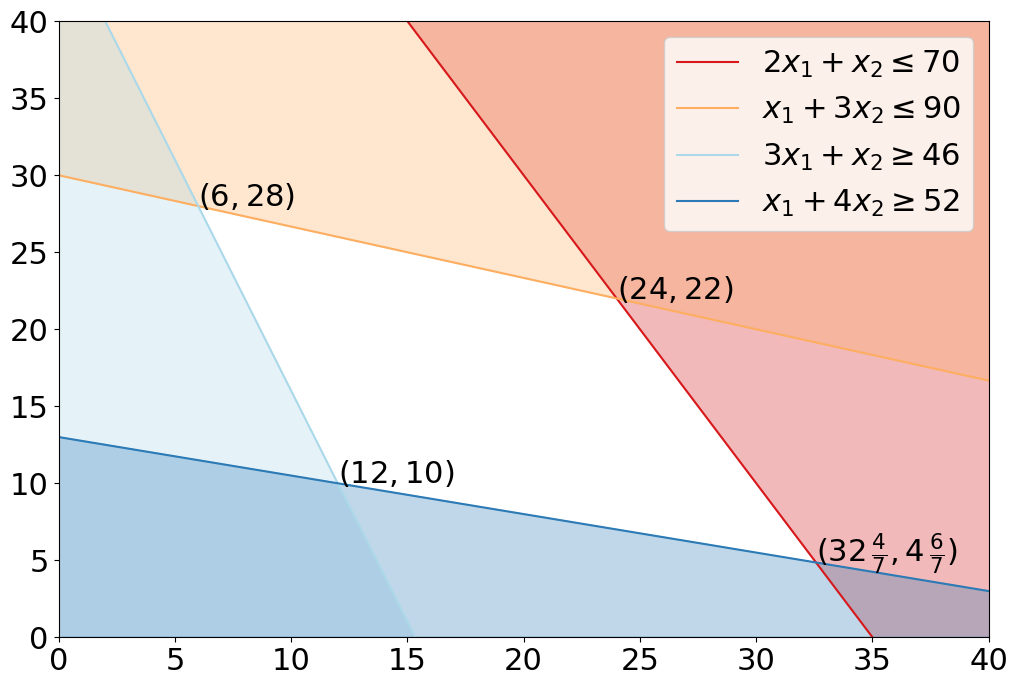

In [2]:
# Generate some points to and plot lines
xpts = np.arange(0,100,1)
ypts = np.arange(0,100,1)
c1 = lambda x: 70 - 2*x
c2 = lambda x: (90 - x)/3
c3 = lambda x: 46 - 3*x
c4 = lambda x: (52 - x)/4

# Some lovely plotting, colours thanks to colorbrewer2.org
plt.rcParams.update({'font.size':22})
plt.figure(figsize=(12,8))

plt.xlim([0,40])
plt.ylim([0,40])

plt.plot(c1(xpts),label = "$2x_1+x_2 \leq 70$",color="#d7191c")
plt.fill_between(xpts,c1(xpts),50,color="#d7191c",alpha=0.3)
plt.plot(c2(xpts),label = "$x_1 + 3x_2 \leq 90$",color="#fdae61")
plt.fill_between(xpts,c2(xpts),50,color="#fdae61",alpha=0.3)
plt.plot(c3(xpts),label = "$3x_1 + x_2 \geq 46$",color="#abd9e9")
plt.fill_between(xpts,c3(xpts),color="#abd9e9",alpha=0.3)
plt.plot(c4(xpts),label = "$x_1+4x_2\geq 52$",color="#2c7bb6")
plt.fill_between(xpts,c4(xpts),color="#2c7bb6",alpha=0.3)

plt.text(12,10,"$(12,10)$")
plt.text(6,28,"$(6,28)$")
plt.text(24,22,"$(24,22)$")
plt.text(228/7,34/7,r"$(32\,\frac{4}{7},4\,\frac{6}{7})$")

plt.legend()
plt.show()

The coordinates of the vertices of the feasible set have been marked and by substituting their values back into the equation to minimise we find that $(24,22)$ solves the problem with a minimised value of $-2280$.

## Task 2 - Dantzig Simplex Algorithm

By first reversing the inequalities of the last two equations above, introducing slack variables and then multiplying by $-1$ where needed to make the RHS's positive we get the standard form of the above probelm:
$$2\, x_1 + x_2 +s_1 = 70 $$
$$x_1 + 3\, x_2 +s_2 = 90 $$
$$ 3\, x_1 + x_2 -s_3 = 46 $$
$$ x_1 + 4\, x_2 -s_4 =  52 $$
With non-negativity constraints
$$x_i,\, s_j \geq 0$$
for the possible $i$ and $j$'s.
This gives us a basic feasible vector 
$$(x_1,\,x_2,\,s_1,\,s_2,\,s_3,\,s_4) = (12,\,10,\,36,\,46,\,0,\,0).$$
We will now implement Dantzig's algorithm. I called it dancing becuase its late and thats what keeps me entertained; stay tuned for even worse in task 4. I will try comment what exactly I'm doing along the way, but this entire thing is a whole lot of slicing and arithmetic gymnastics. It takes as input the initial vertex $x$ of dimension $n+m$ (slack variables included), the (padded with zeros) cost vector $c$, the matrix $A$ and vector $b$ such that our non-trivial constraints read $Ax=b$. It outputs the $n$ dimensional final vertex (slack variables excluded). 

In [3]:
def dancing(x,c,A,b):
    
    # First define what our tolerance for 0 is
    prec = 1e-12
    # First lets check this is a feasible vertex
    if LA.norm(A@x-b)>prec:
        return("Hey dude, you've got to give me something"+
               " I can actually work with. "
              +"Ax-b=",A@x-b)
    
    # The current value of the objective function
    f = np.dot(x,c)
    # This is going to be to disallow negative values later
    vsmall = np.ones(len(b))*prec
    
    # Making the basic and nonbasic variables
    basics = x>prec
    nonbasics = x<=prec
    xb = x[basics]
    xn = x[nonbasics]
    # And corresponding costs
    cb = c[basics]
    cn = c[nonbasics]
    # With corresponding matrices
    B = A[:,basics]
    N = A[:,nonbasics]
    
    # And a matrix inverse
    # (Note, we need not compute it from scratch each time
    #  there is an analytical way to compute it by just
    #  changing one column, but this was easier to implement)
    Binv = LA.inv(B) 
    
    # Okay, here we go, zn is a measure for how the 
    # objective function changes if we increase one of 
    # the nonbasic variables from zero
    zn = cn - np.transpose(N)@np.transpose(Binv)@cb
    # q is the index of the nonbasic variables where 
    # we'd observe the biggest decrease
    q = np.argmin(zn)
    # If we don't observe a decrease anywhere, we're done
    if zn[q]>=0:
        print("The minimised objective function value is ",
              f, "\n at:", x[:len(x)-len(b)])
        return(x[:len(x)-len(b)])
    # Otherwise we will start calculating what value we will
    # give the new basic variable after making it nonbasic
    aq = Binv@N[:,q]
    # After ensuring the problem is indeed bounded
    if all(aq)<=0:
        return("Unbounded Problem")
    # We want to take the minimum of the positive values
    # of a function, so where aq is negative we make it 
    # positive and very small (which will evaluate as 
    # positive and very large in said function)
    vsmall[aq>prec]=aq[aq>prec]
    possxp = np.divide(xb,vsmall)
    # Said min value
    alpha = min(possxp)
    # And where it is
    p = np.argmin(possxp)
    
    # Updating basics and nonbasics
    xn[q]=alpha
    xb = xb - alpha*aq
    A = np.hstack((B,N))
    x = np.hstack((xb,xn))
    c = np.hstack((cb,cn))
    
    print("The next vertex is", x[:len(x)-len(b)])
    
    # Going again
    return(dancing(x,c,A,b))


With the algorithm set up, lets run it on our problem.

In [4]:
x0 = np.array([12,10,36,48,0,0])
c = np.array([-40,-60,0,0,0,0])
A = np.array([[2,1,1,0,0,0],[1,3,0,1,0,0],[3,1,0,0,-1,0],
              [1,4,0,0,0,-1]])
b = np.array([70,90,46,52])
dancing(x0,c,A,b)

The next vertex is [ 6. 28.]
The next vertex is [24. 22.]
The minimised objective function value is  -2280.0 
 at: [24. 22.]


array([24., 22.])

As we can see, it happily walks its way there!

## Task 3 - Gradient Descent

We are looking to minimise over $\mathbb{R}^n$ the quartic function $$f(x)=\frac{1}{4}\left((x-x_*)^TA\cdot(x-x_*)\right)^2$$ (which can be rewritten)
$$
f(x)=\frac{1}{4}\langle x-x_*,A(x-x_*)\rangle^2
$$
with 
$$ A = \left( 
\begin{array}{ccccc} 
\frac{\lambda+1}{2} & \frac{\lambda - 1}{2} & 0 &\ldots & 0\\ 
\frac{\lambda-1}{2} & \frac{\lambda + 1}{2} & 0 &\ldots & 0\\
0 & 0 & 1 &\ldots & 0\\ 
\vdots & \vdots & \vdots &\ddots & \vdots\\ 
0 & 0 & 0 &\ldots & 1
\end{array}
\right),
$$
$$
{x}_* = \left( \begin{array}{c}
\sqrt{2}\\
\sqrt{3}\\
1\\
\vdots\\
1
\end{array}
\right)
$$
and $\frac{1}{10}\leq\lambda\leq 10$.
We can see quite clearly that $x=x_*$ is the solution of the problem as $f(x)$ will always be non-negative and clearly vanishes at $x_*$. The eigenvalues $\mu$ (seeing as you've stolen good old $\lambda$) of $A$ are, as usual, solutions to the characteristic equation which is going to have the form 
$$
c_A(\mu)=(1-\mu)^{n-2}
\begin{vmatrix}
\frac{\lambda+1}{2}-\mu & \frac{\lambda-1}{2}\\
\frac{\lambda-1}{2} & \frac{\lambda+1}{2}-\mu
\end{vmatrix},
$$
due to the specific format of $A$. Once we have identified this form it is quick to solve $\mu=1$ with multiplicity $n-1$ and $\mu=\lambda$ (Ahhh, so it was a hint, hey?). The gradient of $f$ can be calculated if we take advantage of the chain rule and a few familiar results, particularly that for $A$ symmetric (as with ours) $$\frac{d}{dx}x^TAx=2Ax.$$
So we have,
$$ \nabla f(x) = \frac{1}{4}2\frac{d}{dx}\left((x-x_*)^TA(x-x_*)\right)(x-x_*)^TA(x-x_*).$$
This is equivalent to
$$ \nabla f(x) = \frac{1}{2}2A(x-x_*)\left(\frac{d}{dx}(x-x_*)\right)(x-x_*)^TA(x-x_*);$$ which is finally equal to 
$$ \nabla f(x) = A(x-x_*)\langle x-x_*,A(x-x_*)\rangle.$$

We preemtively provide an implementation of golden section search that we will use to perform a line minimisation in our gradient descent algorithm. It takes as input two initial points which you'd want to be sure bracket your minimal value and, of course, the function that we are minimising over. It also takes optional parameters for a tolerance at which point to stop and a maximum number of iterations should the desired accuracy not be reached. It outputs the final value of $b$, which will be bracketed by something that is hopefully less than the tolerance. 

In [5]:
def goldsearch(a,c,f,tol=1e-9,iters=150):
    w = (np.sqrt(5)-1)/2 # The ratio behind everything
    b = a + (c-a)*w # The first trial point
    ct = 0 # Count iterations
    while abs(c-a)>tol:
        ct += 1
        if ct>iters:
            print("Golden Section Search didn't converge,"+
                  "error=",abs(c-a))
            break
        if abs(c-b)>abs(b-a): # If c-b is our bigger section
            x=b+(1-w)*(c-b) # Put x in it in the right place
            if f(b)<f(x): # Update intervals appropriately
                c=x 
            else:
                a,b=b,x
        else:
            x=b-(1-w)*(b-a)
            if f(b)<f(x):
                a=x
            else:
                b,c=x,b
    return(b)

Now we will define some functions that will be useful to our problem in particular. Namely, one that puts together the $x_*$ that is of the correct length based on some starting position vector $x$ (of length at least $2$); as well as the function $f(x)$ and its gradient. 

In [6]:
def xsta(x):
    start = np.array([2,3])
    start = np.sqrt(start)
    rest = np.ones(len(x)-2)
    xstar = np.hstack((start,rest))
    return(xstar)

In [7]:
def fun(x,lam):
    xstar = xsta(x)
    A1 = np.array([[(lam+1)/2, (lam-1)/2],[(lam-1)/2,(lam+1)/2]])
    A2 = np.eye(len(x)-2)
    A = block_diag(A1,A2)
    xdiff = x-xstar
    arg = np.dot(xdiff,A@xdiff)
    return(0.25*np.power(arg,2))

In [8]:
def gradfun(x,lam):
    xstar = xsta(x)
    A1 = np.array([[(lam+1)/2, (lam-1)/2],[(lam-1)/2,(lam+1)/2]])
    A2 = np.eye(len(x)-2)
    A = block_diag(A1,A2)
    xdiff = x-xstar
    return(A@xdiff*np.dot(xdiff,A@xdiff))

And finally we implement our gradient descent algorthm (3 because it is the third generation of my gradual generalise and iterate process). It takes as input the functional forms of $f$ and its gradient, an inital position and optionally a desired tolerance and maximum number of iterations. It returns an array where the columns are the coordinates of where the function is at each step up until termination. 

In [9]:
def graddesc3(f,grad,x0,iters=200,tol=1e-10):
    # Inititalise the output array
    xs = np.zeros((np.size(x0),iters))
    xs[:,0]=x0
    # Set our index to 1
    j=1
    while LA.norm(xs[:,j-1]-xs[:,j-2])>tol and j<iters:
        # Compute the gradient at the current point
        nabla = grad(xs[:,j-1])
        nabla = nabla/LA.norm(nabla)
        # Find the optimal step length (maximum length 100)
        step = goldsearch(0,100,lambda s: f(xs[:,j-1]-s*nabla),tol=1e-15)
        # Take the step
        xs[:,j]=xs[:,j-1]-step*nabla
        # Set the next index
        j=j+1
    # Cut off the unused columns of our array
    if j == iters:
        print('Failed to converge to tolerance in ', iters,'iterations')
    xs = xs[:,:j]
    return(xs)
    
        

Now lets try the problem as provided with $n=2$, $\lambda=2$, $x_0=5x_*$ and a tolerance of $\epsilon = 10^{-15}$.

In [10]:
lam = 2
xs=graddesc3(lambda x: fun(x,lam),
             lambda x: gradfun(x,lam), 5*xsta(np.ones(2)),
            tol=1e-15)

Golden Section Search didn't converge,error= 1.7763568394002505e-15


Don't thing that error is going to matter much, that's a very small interval for $(a,b)$ in the golden section search anyways. Lets check the error of our iterations against the true value.

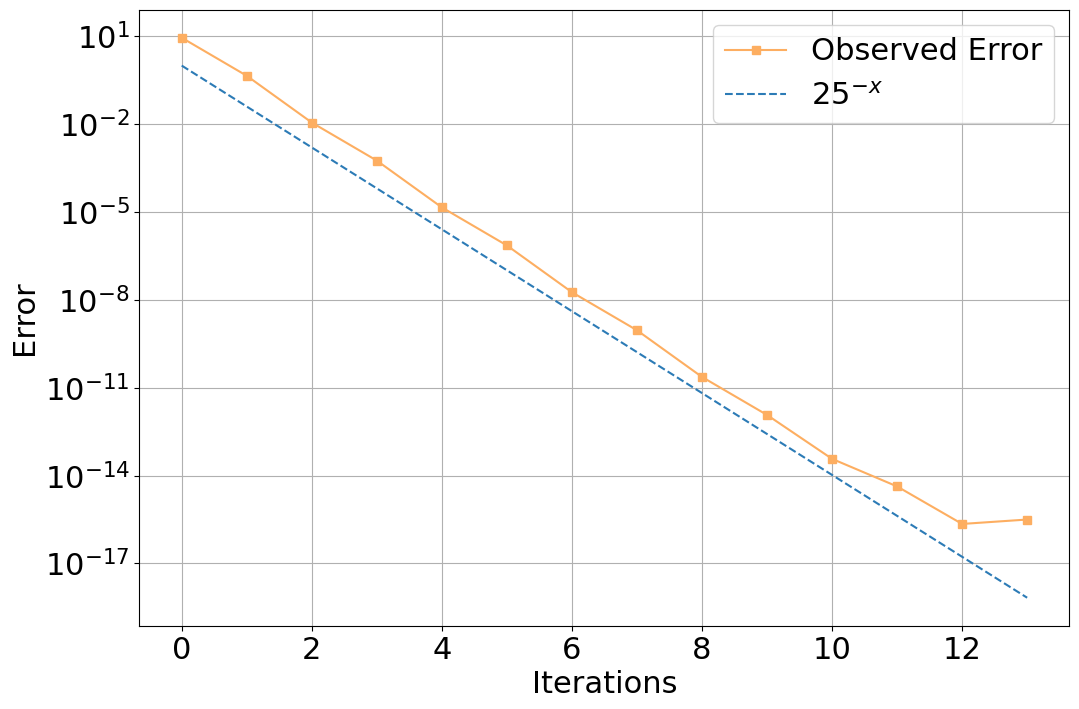

In [11]:
plt.rcParams.update({'font.size':22})
plt.figure(figsize=(12,8))

plt.xlabel('Iterations')
plt.ylabel('Error')

diffs = np.transpose(xs)-xsta(np.ones(2))
diffs = LA.norm(diffs, axis=1)
plt.semilogy(diffs,'s-',label='Observed Error',color="#fdae61")
plt.grid()

xpts = np.linspace(0,13,100)
plt.plot(xpts,np.power(25,-xpts),'--',label='$25^{-x}$',color="#2c7bb6")

plt.legend()
plt.show()

Fantastic. We can see that we converge exponentially fast. Really exponentially fast. How about we plot what our journey looks like in 2D.

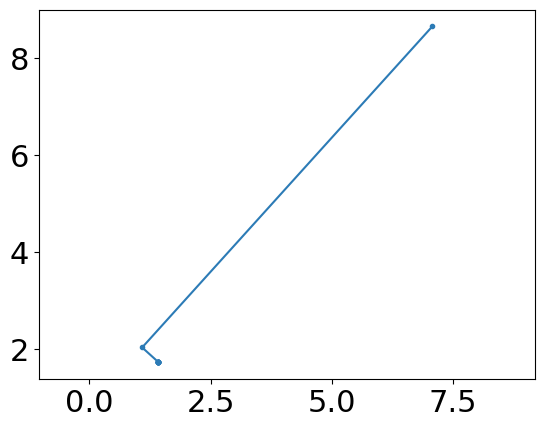

In [12]:
plt.plot(xs[0,:],xs[1,:],'.-',color="#2c7bb6")
plt.axis('equal')
plt.show()

Arguably not particularly illuminating, but we can see it seems to be doing the right thing and is indeed converging very quickly. Perhaps we'll have a nicer plot in an edge case. Lets take the same setting, but this time with $\lambda = 0.1$.

In [13]:
lam = 0.1
xs=graddesc3(lambda x: fun(x,lam),
             lambda x: gradfun(x,lam), 5*np.ones(2),
            tol=1e-12)

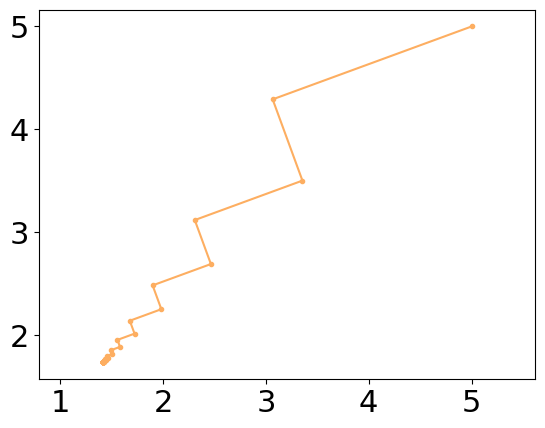

In [14]:
plt.plot(xs[0,:],xs[1,:],'.-',color="#fdae61")
plt.axis('equal')
plt.show()

That's a little more like it! While we still converge exponentially fast though, its a lot less impressive.

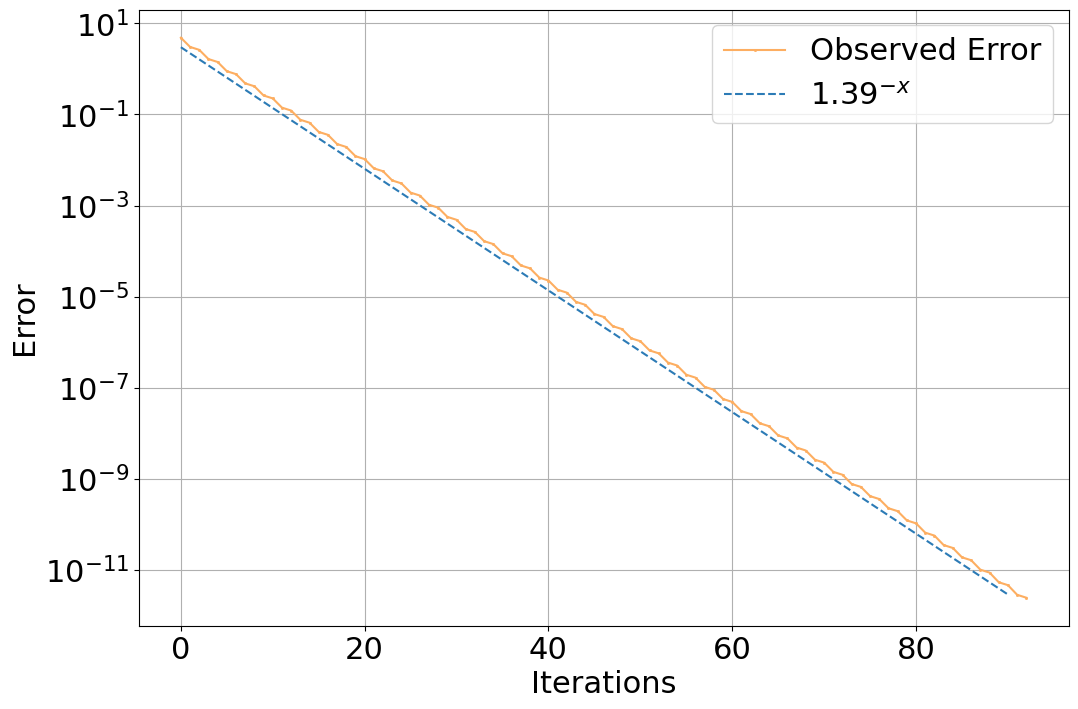

In [15]:
plt.rcParams.update({'font.size':22})
plt.figure(figsize=(12,8))

plt.xlabel('Iterations')
plt.ylabel('Error')

diffs = np.transpose(xs)-xsta(np.ones(2))
diffs = LA.norm(diffs, axis=1)
plt.semilogy(diffs,'s-',label='Observed Error',markersize=1,color="#fdae61")
plt.grid()

xpts = np.linspace(0,90,100)
plt.semilogy(xpts,3*np.power(1.36,-xpts),'--',label='$1.39^{-x}$',color="#2c7bb6")

plt.legend()
plt.show()

See how it takes *much* longer to converge.

One thing I did want to check was that our gradients were indeed orthogonal, particularly for $n>2$. This is because if we plotted slices of ```xs``` in these cases, we would likely not observe the right angles we see above (unless of course, we performed a change of basis). 

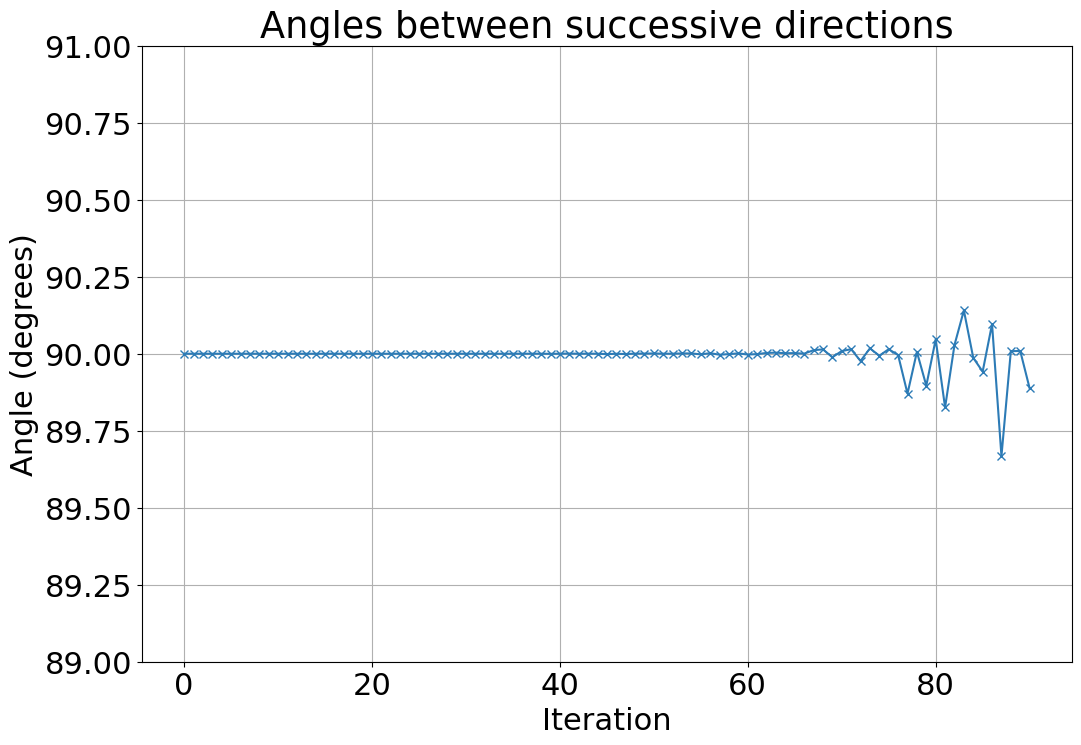

In [16]:
# The seq of vectors
diff=xs[:,1:]-xs[:,:-1]
diff[:,:-1].shape
# Their dot products
dots = np.diag(np.transpose(diff[:,1:])@diff[:,:-1])
lens = LA.norm(diff,axis=0)
# The resulting value of cos(theta)
coss = dots/(lens[:-1]*lens[1:])
thetas = np.degrees(np.arccos(coss))

plt.rcParams.update({'font.size':22})
plt.figure(figsize=(12,8))
plt.plot(thetas,'x-',color="#2c7bb6")
plt.xlabel('Iteration')
plt.ylabel('Angle (degrees)')
plt.title('Angles between successive directions')
plt.ylim([89,91])
plt.grid()
plt.show()



While the accuracy does start to diminish as we get closer to the true value, if we observe the $y$ ticks we find that we are still getting very close to congruent vectors!

Now we will see how the number of required steps when $n=3$ scales with $\lambda$. We will do 20 values between 0.1 and 1 and 20 more between 1 and 10. We will set the tolerance to $10^{-12}$.

In [17]:
lambs = np.hstack((np.linspace(0.1,0.9,19),np.linspace(1,10,20)))
reqits = np.zeros(len(lambs))
for lam in lambs:
    xs=graddesc3(lambda x: fun(x,lam),lambda x: gradfun(x,lam),
                 5*np.ones(3),tol=1e-12)
    reqits[lambs==lam] = len(np.transpose(xs))

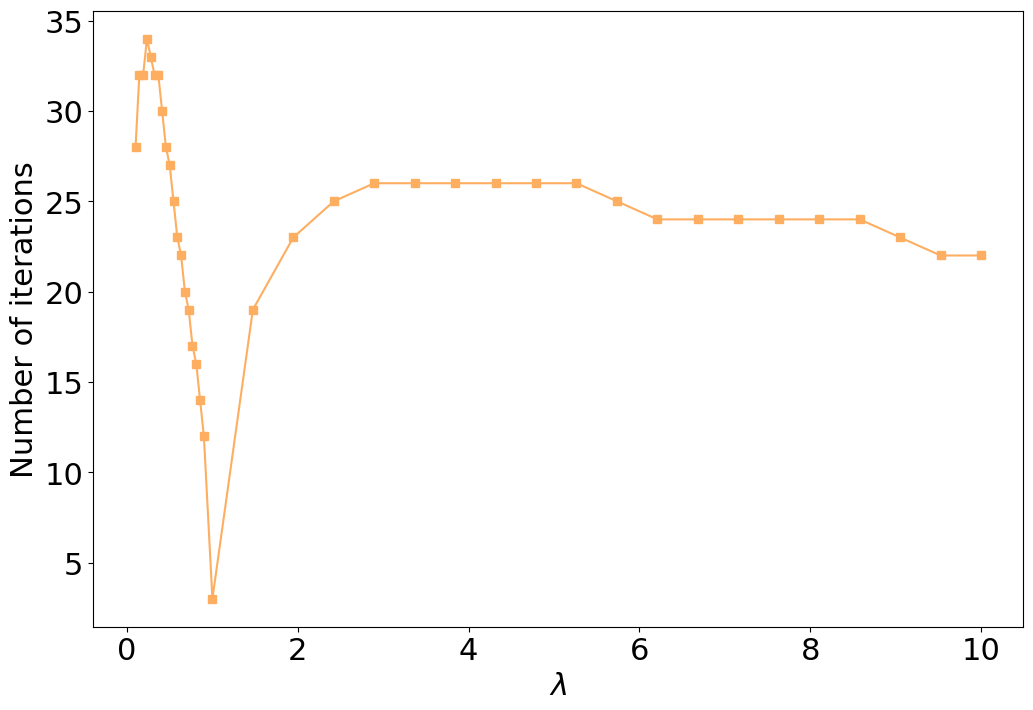

In [18]:
plt.rcParams.update({'font.size':22})
plt.figure(figsize=(12,8))

plt.plot(lambs,reqits,'s-',color="#fdae61")
plt.xlabel(r'$\lambda$')
plt.ylabel('Number of iterations')

plt.show()

The minimum at one is expected because the eigenvalues of the matrix determine the eccentricity of the problem. When $\lambda=1$ the problem is very much not eccentric. Why exactly we observe the behaviour above away from, one, however, I can't explain confidently.

## Task 4 - Stochastic gradient descent

It's late so I'm going to steal from you practically verbatim, feel free to drop to just past the last equation.

We consider the following linear model expressing a noisy relationship between a target variable, $y \in \mathbb{R}$ and a set of predictor variables, ${x} \in \mathbb{R}^n$:

$$ y = \alpha^T \, {x} + \xi $$

where $\alpha \in \mathbb{R}^n$ is a set of parameters and $\xi \sim N(0, \sigma^2)$ is a normal random variable with mean 0 and variance $\sigma^2$ representing the error. We are given a set of $m$ observations

$$Y = \left\{({x}^{(i)},\, y^{(i)})\ : i=1\ldots m \right\}$$

Our task is to find the "best" set of parameters, $\alpha_*$ given the observations by solving the ordinary least squares problem:

$$\alpha_* = \min_{\substack{\alpha \in \mathbb{R}^n} } F(\alpha\, |\, Y)$$

where

$$ F(\alpha\, |\, Y) = \frac{1}{2}\, \frac{1}{m} \sum_{i=1}^m\left( y^{(i)} - \alpha^T\,{x}^{(i)}\right)^2$$

*If you've clocked out maybe here is where you want to come back in!*

To do this we generate test data with 
```
n=10
m=100
xmax = 10.0
sigma = 0.25
```
and we take $\alpha=(1,\,2,\,\dots,\,10)$.

The gradient of out function is given by 
$$\frac{d}{d\alpha}F(\alpha\, |\, Y) = \frac{1}{m} \sum_{i=1}^m\left( y^{(i)} - \alpha^T\,{x}^{(i)}\right){x}^{(i)}.$$
Lets first check that we converge using gradient descent from above starting from a ones vector.

In [19]:
m = 100
n = 10
alphas = np.linspace(1,n,n)
xdata = 10*np.random.rand(n,m)
noise = 0.25*np.random.randn(m)
ydata = np.dot(alphas,xdata) + noise

This is my implementation of $F$, our least squares function and its gradient (and there's a bad joke there if you look hard enough).

In [20]:
def ironman(xdata,ydata,alphas): # Aka Least Square
    m = len(ydata)
    n = len(alphas)
    if np.shape(xdata)!=(n,m):
        return("Hello. Do not be afraid- I am here to help."+
              " Your... input data, it doesn't seem right."+
              " Check it? Good luck human.")
    temp = ydata - np.dot(alphas,xdata)
    temp = np.power(temp,2)
    temp = np.sum(temp)
    return(temp/(2*m))

In [21]:
def suitguy(xdata,ydata,alphas): # Well that's a bit derivative...
    m = len(ydata)
    temp = np.dot(alphas,xdata) - ydata
    temp = xdata*temp
    temp = np.sum(temp,axis=1)
    return(temp/m)

In [22]:
alph = graddesc3(lambda a: ironman(xdata,ydata,a),
          lambda a: suitguy(xdata,ydata,a),
          np.ones(n),tol=1e-12)
print("The obtained value of alpha is \n",alph[:,-1].reshape(10,1))


Golden Section Search didn't converge,error= 1.7763568394002505e-15
Failed to converge to tolerance in  200 iterations
The obtained value of alpha is 
 [[ 1.00337236]
 [ 1.9923249 ]
 [ 2.98853978]
 [ 4.01888936]
 [ 5.00754341]
 [ 6.0072562 ]
 [ 6.98234551]
 [ 7.9950478 ]
 [ 9.0003119 ]
 [10.00503817]]


Although we seem to have failed to converge in 200 iterations (though the code runs in a second or two so we could easily run it for longer), we are already observing an excellent convergence to our true value of $\alpha = (1,\,2,\,\dots,\,10)$, especially given the noise.

Now my idea for stochastic gradient descent is to write a function that does effectively the same exact thing as the gradient descent function above in the way that it handles this problem; the difference will be that when calculating the next descent direction it does not use all $m$ data points in its evaluation of the gradient, but will instead use a minibatch (which is allowed to be a singleton) instead. This could be much less computationally expensive if $m=10^6$ for example.

Radu, I have tried: Different values for $s_0$ and $s_1$, different learning rate functions all together such as $1/\sqrt{n}$ for $n$ the number of iterations, doing a line minimisation again, changing the number of variables, eliminating the noise, rewriting my grad function, taking the entire batch of data, making the problem identical to gradient descent and so on. The only time it works is when it is made identical to gradient descent, by using all $m$ data points and a line-minimiser, and not even with the suggested learning rate. 

I concede. Perhaps not early enough to say I have completely internalised your advice, but the chance of being home by 11 is definitely an improvement. I'll submit when I get in tomorrow morning so you don't give out to me for working on it late at Friday's meeting ;).

In [23]:
def stochdesc(f,grad,x0,xdata,ydata,minbatchsize=1,s0=0.1,
              s1=0.1,lerrate=None,iters=200,tol=1e-3):
    if lerrate == None:
        lerrate = lambda n: s0/(1+s1*n)
    m = len(ydata)
    mingrad = lambda minib: grad(xdata[:,minib],ydata[minib],
                                 alphas)
    # Inititalise the output array
    xs = np.zeros((np.size(x0),iters))
    xs[:,0]=x0
    # Set our index to 1
    j=1
    while LA.norm(xs[:,j-1]-xs[:,j-2])>tol and j<iters:
        # Get the minibatch for the grad
        minib = np.random.choice(m,minbatchsize,replace=False)
        # Compute the gradient at the current point
        nabla = mingrad(minib)
        nabla = nabla/LA.norm(nabla)
        # print(nabla)
        step = lerrate(j)
        # step = goldsearch(0,10,lambda s: f(xs[:,j-1]-s*nabla),tol=1e-15)
        # Take the step
        xs[:,j]=xs[:,j-1]-step*nabla
        # Set the next index
        j=j+1
    # Cut off the unused columns of our array
    xs = xs[:,:j]
    return(xs)
    
        

In [24]:
m=len(ydata)
salph = stochdesc(lambda a: ironman(xdata,ydata,a),
                  suitguy,2*np.ones(n),xdata,ydata,
                  minbatchsize=m,iters=3000,s1=0.001)

In [25]:
print(salph[:,-1].reshape(10,1))

[[ 38.48942558]
 [ 11.26373753]
 [  1.5108199 ]
 [ 94.46627939]
 [ 44.30183915]
 [ 55.23805754]
 [-18.26115077]
 [  8.81137916]
 [ 31.88708292]
 [ 59.09087148]]


Not exactly $\alpha$ is it.